# **Import Libraries**

In [ ]:
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Dataset Paths**

In [ ]:
fer_path = '/content/drive/My Drive/Datasets/FER13/fer2013.csv'
pfer_path = '/content/drive/My Drive/Datasets/FER13/PFED/'
rafd_training_path = '/content/drive/My Drive/Datasets/RAF_DB/train'
rafd_test_path = '/content/drive/My Drive/Datasets/RAF_DB/test/'


# **Loading Dataset for BaseLine Models**


In [ ]:
cut_size = 224
from PIL import Image
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

ptestingset = datasets.ImageFolder(pfer_path , transform= transform_train)
ptestingloader = torch.utils.data.DataLoader(ptestingset, batch_size=8, shuffle=True, num_workers=1)

trainingset = datasets.ImageFolder(rafd_training_path , transform= transform_train)

trainingset, validationset = torch.utils.data.random_split(trainingset, [8000, 4271])

trainingloader = torch.utils.data.DataLoader(trainingset, batch_size=8, shuffle=True, num_workers=1)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=8, shuffle=True, num_workers=1)

testingset = datasets.ImageFolder(rafd_validation_path , transform= transform_train)
testingloader = torch.utils.data.DataLoader(testingset, batch_size=8, shuffle=True, num_workers=1)


In [ ]:
print("Size of TrainLoader ", len(trainingloader.dataset))
print("Size of ValidLoader ",len(validationloader.dataset))
print("Size of TestLoader ",len(testingloader.dataset))
print("Size of PTestLoader ",len(ptestingloader.dataset))



Size of TrainLoader  8000
Size of ValidLoader  4271
Size of TestLoader  3067
Size of PTestLoader  3485


In [ ]:
print("Shape of TrainLoader ", trainingloader.dataset.dataset.class_to_idx)
print("Shape of ValidLoader ", validationloader.dataset.dataset.class_to_idx)
print("Shape of TestLoader ",  testingloader.dataset.class_to_idx)
print("Shape of PTestLoader ",  ptestingloader.dataset.class_to_idx)

Shape of TrainLoader  {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
Shape of ValidLoader  {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
Shape of TestLoader  {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
Shape of PTestLoader  {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


# **Functions for Training And Evaluating Models**

In [ ]:
## Different Functions that will be used to train and evaluate performance of model.

from timeit import default_timer as timer
from tqdm import tqdm
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,n_epochs):
  
    valid_max_acc = 0
    Model_Eval = []

    train_list_acc = []
    valid_list_acc = []
    train_list_cost = []
    valid_list_cost = []
  
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        
        for i, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, dim=1)
            #print("Shape of Pred is ", pred.shape)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            
     

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
      
        train_list_cost.append(train_loss)
        train_list_acc.append(train_acc)
        
        print(f"Training Cost at Epoch No {epoch+1} is {train_loss}" )
        print("Training Accuracy at Epoch No " ,str(epoch+1) , "is ", train_acc)
        
        with torch.no_grad():
             model.eval()  
            #  valid_pbar = tqdm(enumerate(valid_loader))
             for j, (valid_data, valid_target) in enumerate(valid_loader):
                 
                 valid_data, valid_target = valid_data.to(device), valid_target.to(device)
                 output = model(valid_data)
                 loss = criterion(output, valid_target)
                 valid_loss += loss.item() * valid_data.size(0)

                  # Calculate validation accuracy
                 _, pred = torch.max(output, dim=1)
                 correct_tensor = pred.eq(valid_target.data.view_as(pred))
                 accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                 # Multiply average accuracy times the number of examples
                 valid_acc += accuracy.item() * valid_data.size(0)
                 
                #  valid_pbar.set_description( 'Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                #                             .format(epoch, j * len(valid_data), len(valid_loader.dataset),
                #                             100. * j / len(valid_loader),loss.item()))
                 
                

      
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_acc = valid_acc / len(valid_loader.dataset)
        
        valid_list_cost.append(valid_loss)
        valid_list_acc.append(valid_acc)
        
        print("Validation Loss at Epoch No " ,(epoch+1) ," is ",valid_loss)
        print("Validation Accuracy at Epoch No " ,(epoch+1) ,"is ", valid_acc)
       
        torch.save(model.state_dict(), '/content/drive/My Drive/Models/FER13/'+save_file_name)
        print("Model is Successfully Saved")
        print("-------------------------------------------------------")
    
    #Model_Eval.append([train_list_cost, valid_list_cost, train_list_acc, valid_list_acc])
    return model,Model_Eval

def evaluate(model,testloader):
    ## Here Evaluation Function will be written.
    model.eval()
    input, target = testloader
    predicted = model(input)

def accuracy(test_loader,model):
    correct = 0
    total = 0
    label_list= []
    pred_list = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            label_list.extend(labels.cpu().numpy())
            pred_list.extend(predicted.cpu().numpy())
          
    
    ## Going to Calculate Confusion Matrix and F1 Score Using SKLearn:

    acc_score = accuracy_score(label_list, pred_list)
    print("Accuracy Score : ",acc_score)

    c_report =  classification_report(label_list,pred_list) 
    print("\n\nClassification Report")
    print(c_report)

    con_matrix = confusion_matrix(label_list, pred_list) 
    print("\n\nPrining Confusion Matrix: ")
    fig, ax = plt.subplots(figsize=(10,8))
    ticks = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    sns.heatmap(con_matrix, annot=True,cmap= 'Blues', xticklabels = ticks,  yticklabels = ticks)
    
def draw_accuracy_loss(model_eval,epochs):
    
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(epochs)),model_eval[0][0], label="Training Loss")
    plt.plot(list(range(epochs)),model_eval[0][1], label="Validation Loss")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Training and Validation Losses')

    plt.figure(figsize=(8, 6))
    plt.plot(list(range(epochs)),model_eval[0][2], label="Training Accuracy")
    plt.plot(list(range(epochs)),model_eval[0][3], label="Validation Accuracy")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    


# **ResNet18 As BaseLine Model**

In [ ]:
resNet18 = models.resnet18(pretrained=True)
print(resNet18)


In [ ]:
for param in resNet18.parameters():
    param.requires_grad = True   
    
resNet18.fc = nn.Sequential(
               nn.Linear(512, 480),
               nn.ReLU(inplace=True),
               nn.Linear(480, 7))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet18.to(device)
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.9)
save_file_name = "res18_rafd_exp1.pth"

model,model_eval = train(resNet18,criterion,optimizer,trainingloader,validationloader,save_file_name,Epochs)

Training Cost at Epoch No 1 is 1.1918126813173293
Training Accuracy at Epoch No  1 is  0.570875
Validation Loss at Epoch No  1  is  0.8580470441013498
Validation Accuracy at Epoch No  1 is  0.6895340669911518
Model is Successfully Saved
-------------------------------------------------------
Training Cost at Epoch No 2 is 0.7963422823548317
Training Accuracy at Epoch No  2 is  0.72
Validation Loss at Epoch No  2  is  0.6645220698070482
Validation Accuracy at Epoch No  2 is  0.7621166003417478
Model is Successfully Saved
-------------------------------------------------------
Training Cost at Epoch No 3 is 0.6519219092577696
Training Accuracy at Epoch No  3 is  0.76975
Validation Loss at Epoch No  3  is  0.6713094623522579
Validation Accuracy at Epoch No  3 is  0.7604776399109353
Model is Successfully Saved
-------------------------------------------------------
Training Cost at Epoch No 4 is 0.5371816348433495
Training Accuracy at Epoch No  4 is  0.81125
Validation Loss at Epoch No  4 

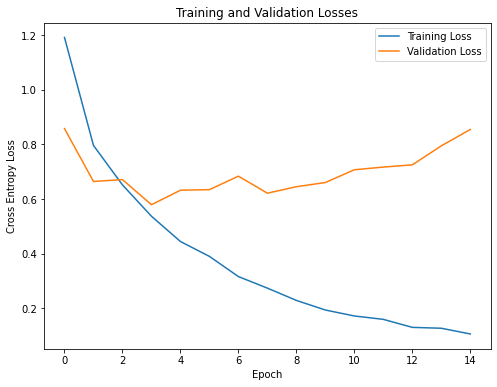

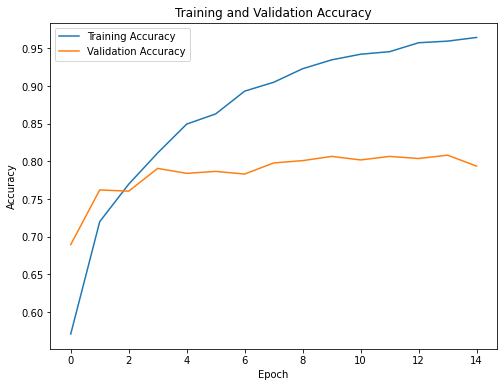

In [ ]:
draw_accuracy_loss(model_eval,15)

# **ResNet18 Accuracy on Source Domain Test Dataset**

Accuracy Score :  0.8017606781871536
Prining Con Matrix: 
[[ 113   15   12   11    5    2    4]
 [  17   99    2   17   16    5    4]
 [   6    1   42    5    2    6   11]
 [   7   21    2 1094   42   13    6]
 [  16   47    1   31  531   34   20]
 [   7   32   11   30   59  334    5]
 [   8   12    7   21   29    6  246]]
Classification Report
              precision    recall  f1-score   support

           0       0.65      0.70      0.67       162
           1       0.44      0.62      0.51       160
           2       0.55      0.58      0.56        73
           3       0.90      0.92      0.91      1185
           4       0.78      0.78      0.78       680
           5       0.83      0.70      0.76       478
           6       0.83      0.75      0.79       329

    accuracy                           0.80      3067
   macro avg       0.71      0.72      0.71      3067
weighted avg       0.81      0.80      0.80      3067



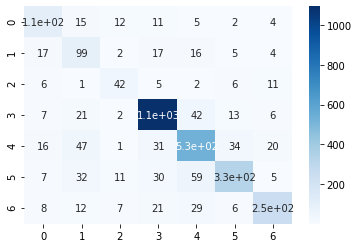

In [ ]:
# resNet18.load_state_dict( torch.load("/content/drive/My Drive/Models/FER13/res18_fer13_exp3.pth"))
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# resNet18.to(device)
accuracy(testingloader,model) 

#**ResNet18 Accuracy on Target Dataset**

Accuracy Score :  0.49784791965566716
Prining Con Matrix: 
[[ 23  32   5  23  77  21   8]
 [ 32  34   3  40  15  22  14]
 [ 18  10   8  14  31   9  32]
 [  7  28  12 871  20   7   5]
 [ 41 150  13 445 625 110  32]
 [  7  50  11  32 107  81  21]
 [ 25  30  13  67 103   8  93]]
Classification Report
              precision    recall  f1-score   support

           0       0.15      0.12      0.13       189
           1       0.10      0.21      0.14       160
           2       0.12      0.07      0.09       122
           3       0.58      0.92      0.71       950
           4       0.64      0.44      0.52      1416
           5       0.31      0.26      0.29       309
           6       0.45      0.27      0.34       339

    accuracy                           0.50      3485
   macro avg       0.34      0.33      0.32      3485
weighted avg       0.51      0.50      0.48      3485



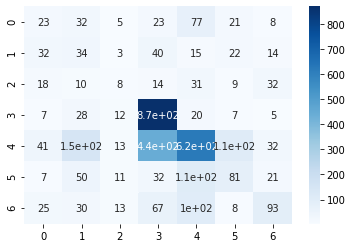

In [ ]:
##resNet18.load_state_dict( torch.load("/content/drive/My Drive/Models/FER13/res18_fer13_exp3.pth"))
##device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
##resNet18.to(device)
accuracy(ptestingloader,resNet18) 

# **VGG16 As BaseLine Model**

In [ ]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

In [ ]:

for param in vgg16.features.parameters():
    param.require_grad = True
   
    

In [ ]:
vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,7,bias=True),                  
                     )

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.8)
save_file_name = "vgg16_rafd_exp1.pth"

model,model_eval = train(vgg16,criterion,optimizer,trainingloader,validationloader,save_file_name,Epochs)

Training Cost at Epoch No 1 is 1.292090473651886
Training Accuracy at Epoch No  1 is  0.52575
Validation Loss at Epoch No  1  is  0.9778650800200989
Validation Accuracy at Epoch No  1 is  0.6541793491125274
Model is Successfully Saved
-------------------------------------------------------
Training Cost at Epoch No 2 is 0.9134790852069855
Training Accuracy at Epoch No  2 is  0.6785
Validation Loss at Epoch No  2  is  0.8459430856521614
Validation Accuracy at Epoch No  2 is  0.7003043784075893
Model is Successfully Saved
-------------------------------------------------------
Training Cost at Epoch No 3 is 0.7653354880362749
Training Accuracy at Epoch No  3 is  0.724375
Validation Loss at Epoch No  3  is  0.7840797239515491
Validation Accuracy at Epoch No  3 is  0.7234839616294098
Model is Successfully Saved
-------------------------------------------------------
Training Cost at Epoch No 4 is 0.6635900056362152
Training Accuracy at Epoch No  4 is  0.766875
Validation Loss at Epoch No  

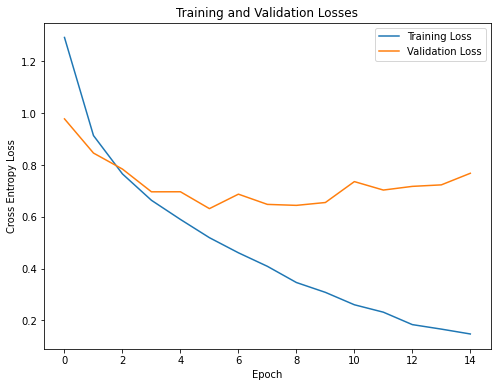

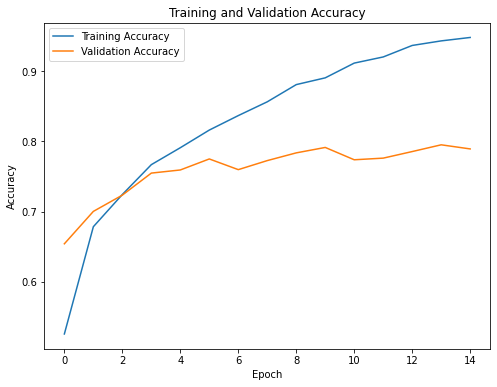

In [ ]:
draw_accuracy_loss(model_eval,15)

# **VGG16 Accuracy on Source Domain Test Dataset**

Accuracy Score :  0.7945875448320835
Prining Con Matrix: 
[[ 115    9    5    9   12    6    6]
 [  19   43    4   16   41   27   10]
 [   4    1   35    4    3    7   19]
 [  11    3    6 1061   63   23   18]
 [   6    9    0   26  543   56   40]
 [   8    7    4   23   62  369    5]
 [   8    0    7    6   27   10  271]]
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       162
           1       0.60      0.27      0.37       160
           2       0.57      0.48      0.52        73
           3       0.93      0.90      0.91      1185
           4       0.72      0.80      0.76       680
           5       0.74      0.77      0.76       478
           6       0.73      0.82      0.78       329

    accuracy                           0.79      3067
   macro avg       0.71      0.68      0.68      3067
weighted avg       0.79      0.79      0.79      3067



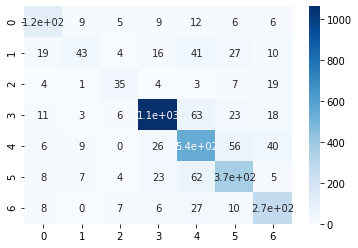

In [ ]:
# vgg16.load_state_dict( torch.load("/content/drive/My Drive/Models/FER13/vgg16_fer_exp2.pth"))
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# vgg16.to(device)
accuracy(testingloader,model) 

# **VGG16 Accuracy on Target Domain Dataset**

Accuracy Score :  0.5236728837876614
Prining Con Matrix: 
[[  8   9   4  10  87  46  25]
 [ 23   9   4  15  28  51  30]
 [  1   2   8   3  36  19  53]
 [ 21   5  37 728  67  73  19]
 [ 29  20  17 222 766 274  88]
 [  8   7   8  10 101 143  32]
 [ 12   2  15  26  82  39 163]]
Classification Report
              precision    recall  f1-score   support

           0       0.08      0.04      0.05       189
           1       0.17      0.06      0.08       160
           2       0.09      0.07      0.07       122
           3       0.72      0.77      0.74       950
           4       0.66      0.54      0.59      1416
           5       0.22      0.46      0.30       309
           6       0.40      0.48      0.44       339

    accuracy                           0.52      3485
   macro avg       0.33      0.35      0.33      3485
weighted avg       0.54      0.52      0.52      3485



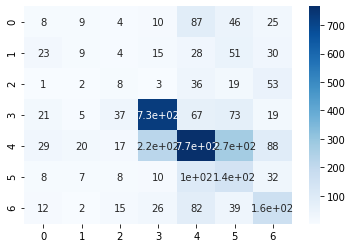

In [ ]:
accuracy(ptestingloader,model) 

# **Models Performance with CycleGAN Transalted Images**

In [ ]:
pfer_path = '/content/drive/My Drive/Datasets/PFER_RGB/PFER/'
pfer_path2  = '/content/drive/My Drive/Translated/PAK_RGB2/'
rafd_translated_training_path = '/content/drive/My Drive/Translated/CycleGAN_Translated_Final/'

In [ ]:
cut_size = 224
from PIL import Image
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

ptestingset = datasets.ImageFolder(pfer_path , transform= transform_train)
ptestingloader = torch.utils.data.DataLoader(ptestingset, batch_size=8, shuffle=True, num_workers=1)

p2testingset = datasets.ImageFolder(pfer_path2 , transform= transform_train)
p2testingloader = torch.utils.data.DataLoader(p2testingset, batch_size=8, shuffle=True, num_workers=1)

trainingset = datasets.ImageFolder(rafd_translated_training_path , transform= transform_train)

trainingset, validationset = torch.utils.data.random_split(trainingset, [12000, 6881])

trainingloader = torch.utils.data.DataLoader(trainingset, batch_size=8, shuffle=True, num_workers=1)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=8, shuffle=True, num_workers=1)

testingset = datasets.ImageFolder(rafd_test_path , transform= transform_train)
testingloader = torch.utils.data.DataLoader(testingset, batch_size=8, shuffle=True, num_workers=1)


In [ ]:
print("Size of TrainLoader ", len(trainingloader.dataset))
#print("Size of ValidLoader ",len(validationloader.dataset))
print("Size of TestLoader ",len(testingloader.dataset))
print("Size of PTestLoader ",len(ptestingloader.dataset))
print("Size of PTestLoader2 ",len(p2testingloader.dataset))



Size of TrainLoader  13057
Size of TestLoader  3067
Size of PTestLoader  2848
Size of PTestLoader2  725


In [ ]:
print("Shape of TrainLoader ", trainingloader.dataset.class_to_idx)
#print("Shape of ValidLoader ", validationloader.dataset.dataset.class_to_idx)
print("Shape of TestLoader ",  testingloader.dataset.class_to_idx)
print("Shape of PTestLoader ",  ptestingloader.dataset.class_to_idx)
print("Shape of P2TestLoader ",  p2testingloader.dataset.class_to_idx)

Shape of TrainLoader  {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
Shape of TestLoader  {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
Shape of PTestLoader  {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
Shape of P2TestLoader  {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


# **ResNet18 FineTuned with CycleGAN Translated Images**

In [ ]:
# Load the pretrained model from pytorch
resNet18 = models.resnet18(pretrained=True)
#print(resNet18)

In [ ]:
for param in resNet18.parameters():
    param.requires_grad = True   
    
resNet18.fc = nn.Sequential(
               nn.Linear(512, 480),
               nn.ReLU(inplace=True),
               nn.Linear(480, 7))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet18.to(device)
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.7)
save_file_name = "final_res18_rafd_translated_exp.pth"

model,model_eval = train(resNet18,criterion,optimizer,trainingloader,save_file_name,Epochs)

# **Fine-Tuned ResNet18 Accuracy on Target Dataset1**

Accuracy Score :  0.47928370786516855


Classification Report
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       159
           1       0.15      0.09      0.11       143
           2       0.25      0.25      0.25       102
           3       0.63      0.83      0.71       838
           4       0.65      0.38      0.48      1091
           5       0.17      0.32      0.23       234
           6       0.37      0.44      0.40       281

    accuracy                           0.48      2848
   macro avg       0.33      0.34      0.33      2848
weighted avg       0.51      0.48      0.47      2848



Prining Confusion Matrix: 


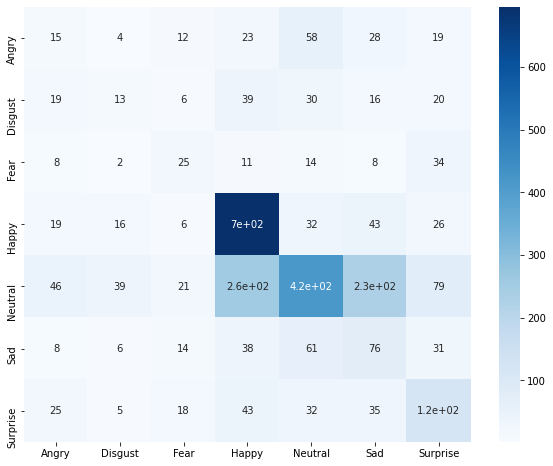

In [ ]:
resNet18.load_state_dict( torch.load("/content/drive/My Drive/Models/FER13/res18_rafd_translated_exp2.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet18.to(device)
accuracy(ptestingloader,resNet18) 

# **Fine-Tuned ResNet18 Accuracy on Target Dataset2**

Accuracy Score :  0.3351724137931035


Classification Report
              precision    recall  f1-score   support

           0       0.71      0.09      0.16       137
           1       0.05      0.01      0.02        74
           2       0.00      0.00      0.00        38
           3       0.37      0.86      0.52       138
           4       0.35      0.34      0.34       201
           5       0.11      0.10      0.11        70
           6       0.36      0.55      0.44        67

    accuracy                           0.34       725
   macro avg       0.28      0.28      0.23       725
weighted avg       0.35      0.34      0.28       725



Prining Confusion Matrix: 


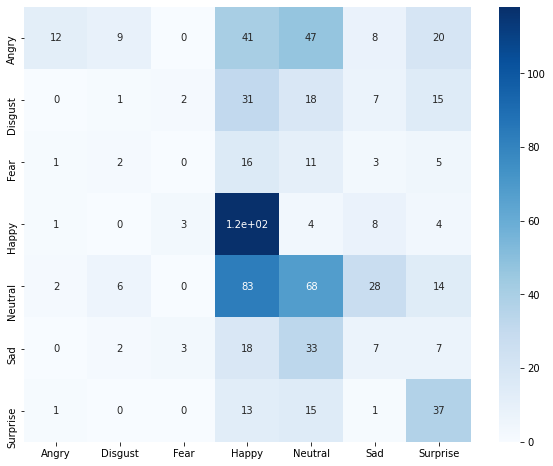

In [ ]:
accuracy(p2testingloader,model) 

# **VGG16 Fine-Tuned with CycleGAN Translated Images**

In [ ]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

In [ ]:

for param in vgg16.features.parameters():
    param.require_grad = True
  

In [ ]:
vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,7,bias=True),                  
                     )

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Epochs = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.7)
save_file_name = "vgg16_rafd_translated_exp1.pth"

model,model_eval = train(vgg16,criterion,optimizer,trainingloader,save_file_name,Epochs)

## **Fine-Tuned VGG16 Accuracy on Target Dataset2**

Accuracy Score :  0.36


Classification Report
              precision    recall  f1-score   support

           0       0.50      0.23      0.32       137
           1       0.14      0.14      0.14        74
           2       0.00      0.00      0.00        38
           3       0.52      0.75      0.61       138
           4       0.44      0.28      0.34       201
           5       0.20      0.57      0.29        70
           6       0.41      0.30      0.34        67

    accuracy                           0.36       725
   macro avg       0.32      0.32      0.29       725
weighted avg       0.39      0.36      0.35       725



Prining Confusion Matrix: 


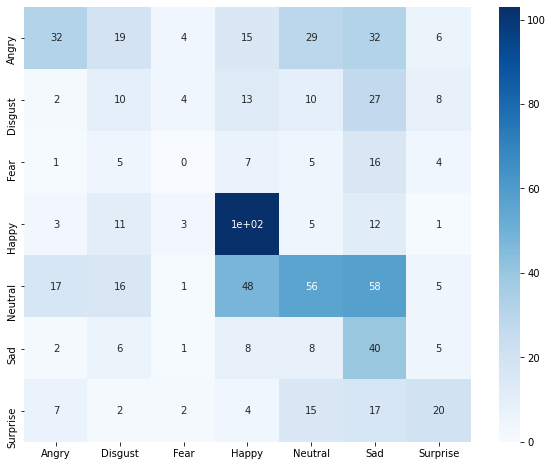

In [ ]:
vgg16.load_state_dict( torch.load("/content/drive/My Drive/Models/FER13/vgg16_rafd_translated_exp1.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
accuracy(p2testingloader,vgg16) 

## **Fine-Tuned VGG16 Accuracy on Target Dataset1**

Accuracy Score :  0.43644662921348315


Classification Report
              precision    recall  f1-score   support

           0       0.18      0.22      0.20       159
           1       0.12      0.19      0.15       143
           2       0.28      0.23      0.25       102
           3       0.76      0.67      0.71       858
           4       0.67      0.34      0.45      1071
           5       0.16      0.61      0.25       234
           6       0.50      0.30      0.37       281

    accuracy                           0.44      2848
   macro avg       0.38      0.36      0.34      2848
weighted avg       0.57      0.44      0.47      2848



Prining Confusion Matrix: 


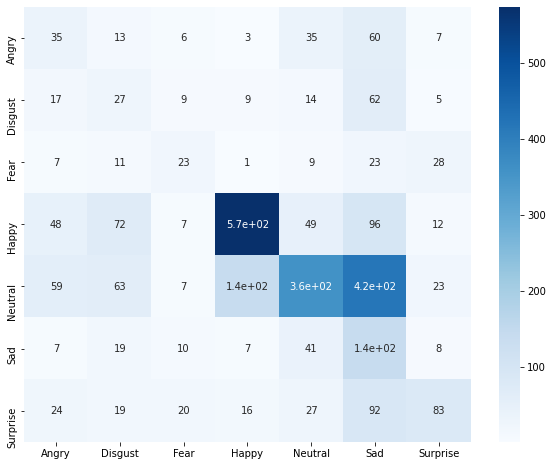

In [ ]:
vgg16.load_state_dict( torch.load("/content/drive/My Drive/Models/FER13/vgg16_rafd_translated_exp1.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
accuracy(ptestingloader,vgg16) 